In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from datetime import datetime

%matplotlib inline

In [3]:
#You know Excel is crap at .csv so just let pandas handle the conversion

excel_path = r'E:\Python\work\area chart\births_and_deaths.xlsx'
csv_path = r'E:\Python\work\area chart\births_and_deaths.csv'

df = pd.read_excel(excel_path)
df.to_csv(csv_path, index=False)

In [4]:
df = pd.read_csv(csv_path)

In [5]:
#Tidy up column names and formatting

df['str_year'] = '01/01/' + df['Year of registration'].astype(str)

df['reg_year'] = pd.to_datetime(df['str_year'])

df.rename(columns={'Council Area': 'council_area', 'Births': 'num_births', 'Deaths':'num_deaths'}, inplace=True)

df.drop(['Year of registration', 'str_year'], axis=1, inplace=True)

In [6]:
#calculate percent of total for deaths and births for each year

df['pct_births'] = df['num_births'] / (df['num_births'] + df['num_deaths'])
df['pct_deaths'] = df['num_deaths'] / (df['num_births'] + df['num_deaths'])

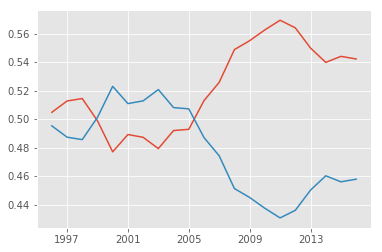

In [7]:
#create masks for filtering

mask = df['council_area'] == 'Aberdeen City'

#don't forget to sort!

x = np.array(sorted(df[mask].reg_year.values))

f = df[mask].sort_values(['reg_year']).pct_births.values

g = df[mask].sort_values(['reg_year']).pct_deaths.values

#plot for reference

plt.style.use('ggplot')

plt.plot(x, f, '-')
plt.plot(x, g, '-')


In [8]:
df_grp = df[mask].groupby(['council_area', 'reg_year']).min()

In [9]:
df_grp

num_births  num_deaths  pct_births  pct_deaths
council_area  reg_year                                                  
Aberdeen City 1996-01-01        2402        2357    0.504728    0.495272
              1997-01-01        2366        2249    0.512676    0.487324
              1998-01-01        2339        2208    0.514405    0.485595
              1999-01-01        2311        2322    0.498813    0.501187
              2000-01-01        2088        2289    0.477039    0.522961
              2001-01-01        2097        2190    0.489153    0.510847
              2002-01-01        2098        2208    0.487227    0.512773
              2003-01-01        2003        2176    0.479301    0.520699
              2004-01-01        2075        2143    0.491939    0.508061
              2005-01-01        2061        2121    0.492826    0.507174
              2006-01-01        2200        2089    0.512940    0.487060
              2007-01-01        2417        2180    0.525778    0.474222
              2008-01-01        2596        2135    0.548721    0.451279
              2009-01-01        2564        2056    0.554978    0.445022
              2010-01-01        2599        2021    0.562554    0.437446
              2011-01-01        2608        1973    0.569308    0.430692
              2012-01-01        2688        2078    0.563995    0.436005
              2013-01-01        2500        2047    0.549813    0.450187
              2014-01-01        2565        2187    0.539773    0.460227
              2015-01-01        2609        2187    0.543995    0.456005
              2016-01-01        2521        2129    0.542151    0.457849

In [19]:
#create polygon geometry for import to Tableau.

#define polygon coordinate lists

#Currently works to the n-1 polygons. Need to make sure the last polygon is captured too.

x_temp = []
poly_y_temp = []
new_y_temp = []
return_y_temp = []

poly_y = []
poly_x = []
new_final = []
return_final = []

#define polygon parameters

poly_id = []
path_order = []
poly_colour =[]

polygon_id = 1


#main loop

for i in range(len(df_grp)-1):

    new_y1 = df_grp['pct_births'].iloc[i]
    new_y2 = df_grp['pct_births'].iloc[i+1]
    return_y1 = df_grp['pct_deaths'].iloc[i]
    return_y2 = df_grp['pct_deaths'].iloc[i+1]
    x1 = df_grp.index.get_level_values('reg_year')[i].timestamp() #shapely needs it for calculations
    x2 = df_grp.index.get_level_values('reg_year')[i+1].timestamp()
    
    line1 = LineString([(x1,new_y1), (x2,new_y2)])
    line2 = LineString([(x1,return_y1), (x2,return_y2)])
    
    xcom = line1.intersection(line2)
    
    #If i is at the end, create the last polygon
    
    if i == len(df_grp)-2:
        
        x_temp = x_temp + list(reversed(x_temp))
        poly_x.extend(x_temp)
        path_order.extend(list(range(1, len(x_temp)+1)))
        poly_id.extend([polygon_id]*(len(x_temp)))
          
        new_final.extend(new_y_temp + list(reversed(new_y_temp)))        
        return_final.extend(return_y_temp + list(reversed(return_y_temp)))
        
        poly_y_temp = new_y_temp + list(reversed(return_y_temp))
        poly_y.extend(poly_y_temp)
        
        if new_y1 > return_y1:
            
            poly_colour.extend([1]*(len(poly_y_temp)))
            
        else:
            
            poly_colour.extend([0]*(len(poly_y_temp)))
    
        print('ha-ha')
    
    else:
        
    
        if xcom.is_empty:

            new_y_temp.extend([new_y1, new_y2])
            return_y_temp.extend([return_y1, return_y2])
            x_temp.extend([x1, x2])

        else:

            #create poly_x

            x_temp.append(xcom.x)
            x_temp = x_temp[:-1]+list(reversed(x_temp))
            poly_x.extend(x_temp)

            #write polygon parameters

            path_order.extend(list(range(1, len(x_temp)+1)))
            poly_id.extend([polygon_id]*(len(x_temp)))
            polygon_id += 1

            #flush x_temp

            x_temp = []

            #create new and return original lines in a matching order with poly_x

            new_y_temp.append(xcom.y)       
            new_final.extend(new_y_temp[:-1] + list(reversed(new_y_temp)))

            return_y_temp.append(xcom.y)
            return_final.extend(return_y_temp[:-1] + list(reversed(return_y_temp)))

            #create polygon y values

            poly_y_temp = new_y_temp[:-1] + list(reversed(return_y_temp))
            poly_y.extend(poly_y_temp)

            #add colour flag

            if new_y1 > return_y1:

                poly_colour.extend([1]*(len(poly_y_temp)))

            else:

                poly_colour.extend([0]*(len(poly_y_temp)))

            #flush all temps

            new_y_temp = []
            return_y_temp = []
            poly_y_temp = []

            #start new polygon

            x_temp.extend([xcom.x, x2])
            new_y_temp.extend([xcom.y, new_y2])
            return_y_temp.extend([xcom.y, return_y2])

print('done')

ha-ha
done


In [16]:
polygon_id

3

In [20]:
#fix the dates and export

new_dates = []

for d in poly_x:
    new_dates.append(datetime.fromtimestamp(d))

poly_df = pd.DataFrame({'date':new_dates, 'poly_y':poly_y, 'path_id':path_order,
                        'poly_id':poly_id, 'poly_colour': poly_colour,
                       'new_y':new_final, 'return_y': return_final})

poly_df.to_csv(r'E:\Python\work\area chart\aberdeen_polygons.csv', index=False)